In [1]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
# from keras.datasets import mnist
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras import backend as K
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score
from time import time
from scipy.spatial.distance import euclidean
from sklearn.metrics import average_precision_score

/Users/tradergllc/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Prepare Reality Mining Data

In [2]:
# Apps By Week
df = pd.read_csv('/Users/tradergllc/rsi/datasets/proc/newsgroups/', 
                 sep=', ', header=None, engine='python', dtype=str, names=['id', 'date', 'app', 'freq'])

In [3]:
# Clean app names
# for r in range(len(df.index)):
#     if df.iloc[r, 2].find(':') > -1:
#         print df.iloc[r]
#         df.iloc[r, 2] = 'Phone'

In [4]:
df['app'].unique()

array(['ScreenSaver', 'context_log', 'BtUi', 'Logs', 'Pinboard', 'mixpix',
       'Phone', 'Phonebook', 'Camera', 'Menu', 'SysAp', 'profileapp',
       'Browser', 'FExplorer', 'FaxModemUi', 'gs', 'Appmngr',
       'Videorecorder', 'VCommand', 'mce', 'NpdViewer', 'Voicerecorder',
       'Switcher', 'MediaGallery', 'Calendar', 'mmcapp', 'FileManager',
       'contextbook', 'www', 'ClockApp', 'JavaAware', 'PSLN',
       'MediaPlayer', 'Appinst', 'ConnectionMonitorUi', 'Cam', 'cshelp',
       'ToDo', 'Notepad', 'KPCaMain', 'ImageViewer', 'Speeddial', 'Pop2',
       'MupeClient', 'SmsEditor', 'CbsUiApp', 'Ussd', 'Pang',
       'ChessBuddy', 'Emonic', 'ChessMaster', 'SpeedDevils',
       'RainbowSix3', 'DRIV3R', 'Fisherman', 'exbubble', 'AgileMessenger',
       'Sos', 'Satui', 'MGS', 'CasinoWar', 'ZooBattle', 'RocketGirl',
       'mStopwatch', 'BrutalFightingMIDlet', 'CaribbeanPoker',
       'BaywatchBeachVolleyball', 'ZombieMansion', 'MobileSense',
       'SnakeEx', 'CtrlFreak', 'RSPrint', 

In [5]:
def convert_to_dict(df, col='app'):
    data_dict = {}
    
    unique = list(df[col].unique())
    
    pid = int(df.iloc[0,0])
    date = df.iloc[0, 1]
    data_dict[pid] = {}
    data_dict[pid][date] = np.zeros((len(unique),))
    
    for r in range(1, len(df.index)):
        if int(df.iloc[r, 0]) != pid:
            pid = int(df.iloc[r, 0])
            data_dict[pid] = {}
            date = None
        
        if df.iloc[r, 1] == date:
            try:
                data_dict[pid][date][unique.index(df.iloc[r, 2])] = 1 #df.iloc[r, 3]
            except ValueError:
                pass
        else:
            date = df.iloc[r, 1]
            data_dict[pid][date] = np.zeros((len(unique),))
            try:
                data_dict[pid][date][unique.index(df.iloc[r, 2])] = 1 #int(df.iloc[r, 3])
            except ValueError:
                pass
    return data_dict, unique

In [6]:
data_dict, unique = convert_to_dict(df)

In [7]:
def dict_to_np_array(d):
    vector_list = []
    gt_pid = []
    for pid in d.keys():
        for date in d[pid].keys():
            vector_list.append(d[pid][date])
            gt_pid.append(d.keys().index(pid))
    return np.stack(vector_list), np.array(gt_pid)

In [8]:
x_train, y_train = dict_to_np_array(data_dict)
print x_train.shape, y_train.shape

(1911, 206) (1911,)


In [9]:
# x_train = x_train / (x_train.max(axis=1)[:, None] + 1e-5)

In [10]:
x_train

array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

### Train VAE

In [11]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [12]:
original_dim = len(unique)

# network parameters
input_shape = (original_dim, )
intermediate_dim = 10
batch_size = 128
latent_dim = 2
# epochs = 50

In [13]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 206)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           2070        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            22          dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            22          dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [14]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_3 (Dense)              (None, 206)               2266      
Total params: 2,296
Trainable params: 2,296
Non-trainable params: 0
_________________________________________________________________


In [15]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [16]:
reconstruction_loss = categorical_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=Adam(lr=0.001, decay=1.0e-6))
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 206)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 2114      
_________________________________________________________________
decoder (Model)              (None, 206)               2296      
Total params: 4,410
Trainable params: 4,410
Non-trainable params: 0
_________________________________________________________________


In [17]:
vae.fit(x_train,
        epochs=1000,
        batch_size=batch_size)

Epoch 1/1000
1911/1911 [==============================] - 1s 276us/step - loss: 13600.6651
Epoch 2/1000
1911/1911 [==============================] - 0s 53us/step - loss: 13321.4786
Epoch 3/1000
1911/1911 [==============================] - 0s 40us/step - loss: 12808.6172
Epoch 4/1000
1911/1911 [==============================] - 0s 32us/step - loss: 12016.9715
Epoch 5/1000
1911/1911 [==============================] - 0s 33us/step - loss: 11095.3370
Epoch 6/1000
1911/1911 [==============================] - 0s 33us/step - loss: 10313.5134
Epoch 7/1000
1911/1911 [==============================] - 0s 43us/step - loss: 9817.4306
Epoch 8/1000
1911/1911 [==============================] - 0s 42us/step - loss: 9599.8345
Epoch 9/1000
1911/1911 [==============================] - 0s 42us/step - loss: 9477.8515
Epoch 10/1000
1911/1911 [==============================] - 0s 40us/step - loss: 9386.0190
Epoch 11/1000
1911/1911 [==============================] - 0s 34us/step - loss: 9313.4473
Epoch 12/100

1911/1911 [==============================] - 0s 41us/step - loss: 8443.7963
Epoch 93/1000
1911/1911 [==============================] - 0s 31us/step - loss: 8440.4663
Epoch 94/1000
1911/1911 [==============================] - 0s 26us/step - loss: 8438.0942
Epoch 95/1000
1911/1911 [==============================] - 0s 27us/step - loss: 8434.2090
Epoch 96/1000
1911/1911 [==============================] - 0s 27us/step - loss: 8431.9647
Epoch 97/1000
1911/1911 [==============================] - 0s 50us/step - loss: 8429.2117
Epoch 98/1000
1911/1911 [==============================] - 0s 53us/step - loss: 8425.9307
Epoch 99/1000
1911/1911 [==============================] - 0s 52us/step - loss: 8423.6846
Epoch 100/1000
1911/1911 [==============================] - 0s 55us/step - loss: 8421.5383
Epoch 101/1000
1911/1911 [==============================] - 0s 54us/step - loss: 8419.2936
Epoch 102/1000
1911/1911 [==============================] - 0s 56us/step - loss: 8416.5775
Epoch 103/1000
1911/1

1911/1911 [==============================] - 0s 26us/step - loss: 8250.7846
Epoch 273/1000
1911/1911 [==============================] - 0s 26us/step - loss: 8250.8867
Epoch 274/1000
1911/1911 [==============================] - 0s 25us/step - loss: 8250.3009
Epoch 275/1000
1911/1911 [==============================] - 0s 27us/step - loss: 8249.9014
Epoch 276/1000
1911/1911 [==============================] - 0s 27us/step - loss: 8250.4941
Epoch 277/1000
1911/1911 [==============================] - 0s 27us/step - loss: 8250.3253
Epoch 278/1000
1911/1911 [==============================] - 0s 28us/step - loss: 8249.5062
Epoch 279/1000
1911/1911 [==============================] - 0s 27us/step - loss: 8249.6382
Epoch 280/1000
1911/1911 [==============================] - 0s 27us/step - loss: 8248.7330
Epoch 281/1000
1911/1911 [==============================] - 0s 27us/step - loss: 8248.5032
Epoch 282/1000
1911/1911 [==============================] - 0s 27us/step - loss: 8249.2173
Epoch 283/1000

1911/1911 [==============================] - 0s 26us/step - loss: 8208.2968
Epoch 453/1000
1911/1911 [==============================] - 0s 28us/step - loss: 8207.1710
Epoch 454/1000
1911/1911 [==============================] - 0s 27us/step - loss: 8207.1676
Epoch 455/1000
1911/1911 [==============================] - 0s 26us/step - loss: 8207.2989
Epoch 456/1000
1911/1911 [==============================] - 0s 27us/step - loss: 8207.1065
Epoch 457/1000
1911/1911 [==============================] - 0s 26us/step - loss: 8206.8636
Epoch 458/1000
1911/1911 [==============================] - 0s 26us/step - loss: 8208.1275
Epoch 459/1000
1911/1911 [==============================] - 0s 26us/step - loss: 8207.9757
Epoch 460/1000
1911/1911 [==============================] - 0s 28us/step - loss: 8206.6796
Epoch 461/1000
1911/1911 [==============================] - 0s 27us/step - loss: 8205.7028
Epoch 462/1000
1911/1911 [==============================] - 0s 26us/step - loss: 8205.9801
Epoch 463/1000

1911/1911 [==============================] - 0s 44us/step - loss: 8180.7391
Epoch 632/1000
1911/1911 [==============================] - 0s 39us/step - loss: 8180.5851
Epoch 633/1000
1911/1911 [==============================] - 0s 33us/step - loss: 8179.7230
Epoch 634/1000
1911/1911 [==============================] - 0s 38us/step - loss: 8180.7231
Epoch 635/1000
1911/1911 [==============================] - 0s 40us/step - loss: 8180.1476
Epoch 636/1000
1911/1911 [==============================] - 0s 34us/step - loss: 8179.6075
Epoch 637/1000
1911/1911 [==============================] - 0s 33us/step - loss: 8179.1231
Epoch 638/1000
1911/1911 [==============================] - 0s 43us/step - loss: 8179.2954
Epoch 639/1000
1911/1911 [==============================] - 0s 42us/step - loss: 8178.7001
Epoch 640/1000
1911/1911 [==============================] - 0s 33us/step - loss: 8178.5059
Epoch 641/1000
1911/1911 [==============================] - 0s 36us/step - loss: 8178.7457
Epoch 642/1000

Epoch 810/1000
1911/1911 [==============================] - 0s 44us/step - loss: 8162.2017
Epoch 811/1000
1911/1911 [==============================] - 0s 52us/step - loss: 8163.2037
Epoch 812/1000
1911/1911 [==============================] - 0s 47us/step - loss: 8162.3506
Epoch 813/1000
1911/1911 [==============================] - 0s 44us/step - loss: 8161.5090
Epoch 814/1000
1911/1911 [==============================] - 0s 41us/step - loss: 8161.1573
Epoch 815/1000
1911/1911 [==============================] - 0s 42us/step - loss: 8161.4395
Epoch 816/1000
1911/1911 [==============================] - 0s 49us/step - loss: 8161.7873
Epoch 817/1000
1911/1911 [==============================] - 0s 50us/step - loss: 8161.3857
Epoch 818/1000
1911/1911 [==============================] - 0s 58us/step - loss: 8161.5268
Epoch 819/1000
1911/1911 [==============================] - 0s 37us/step - loss: 8160.8180
Epoch 820/1000
1911/1911 [==============================] - 0s 26us/step - loss: 8160.9756

1911/1911 [==============================] - 0s 48us/step - loss: 8153.1934
Epoch 901/1000
1911/1911 [==============================] - 0s 45us/step - loss: 8153.9594
Epoch 902/1000
1911/1911 [==============================] - 0s 47us/step - loss: 8153.0169
Epoch 903/1000
1911/1911 [==============================] - 0s 47us/step - loss: 8152.1166
Epoch 904/1000
1911/1911 [==============================] - 0s 48us/step - loss: 8152.3569
Epoch 905/1000
1911/1911 [==============================] - 0s 51us/step - loss: 8153.2301
Epoch 906/1000
1911/1911 [==============================] - 0s 45us/step - loss: 8152.5879
Epoch 907/1000
1911/1911 [==============================] - 0s 47us/step - loss: 8153.2120
Epoch 908/1000
1911/1911 [==============================] - 0s 47us/step - loss: 8153.5783
Epoch 909/1000
1911/1911 [==============================] - 0s 48us/step - loss: 8152.7885
Epoch 910/1000
1911/1911 [==============================] - 0s 46us/step - loss: 8151.4373
Epoch 911/1000

In [44]:
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs[2])

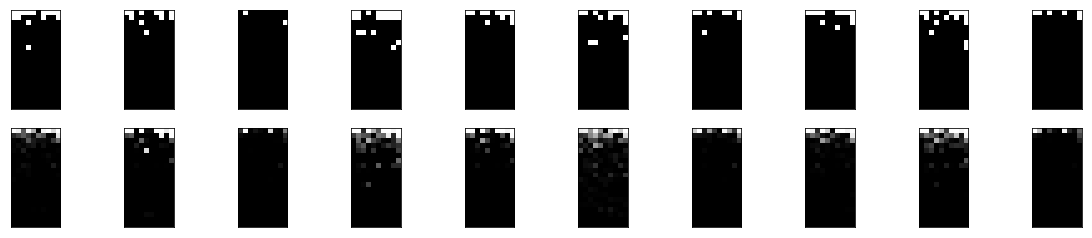

In [49]:
# n = 10  # how many digits we will display
choice = np.random.choice(range(len(x_train)), n, replace=False)
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[choice[i], :200].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[choice[i], :200].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

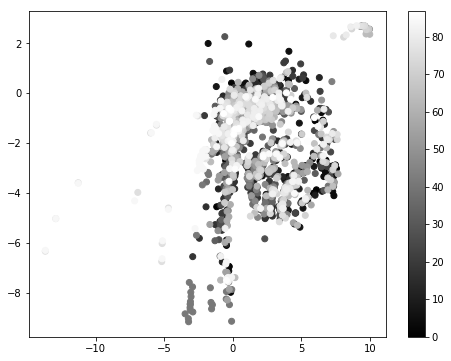

In [20]:
x_test_encoded = encoder.predict(x_train, batch_size=batch_size)
x_test_encoded = np.array(x_test_encoded)
plt.figure(figsize=(8, 6))
plt.scatter(x_test_encoded[2, :, 0], x_test_encoded[2, :, 1], c=y_train)
plt.colorbar()
plt.show()

In [21]:
pair_dist = []
pair_label = []
pair_score =[]

for i in np.arange(x_test_encoded[2].shape[0]):
    for j in range(i + 1, x_test_encoded[2].shape[0]):
        d = np.sqrt(np.power(x_test_encoded[2, i] - x_test_encoded[2, j], 2).sum())
        pair_dist.append(d)
        pair_score.append(1 / (d + 1.0e-5))
        
        if y_train[i] == y_train[j]:
            pair_label.append(True)
        else:
            pair_label.append(False)

print roc_auc_score(y_true=pair_label, y_score=pair_score)

0.573102212831025


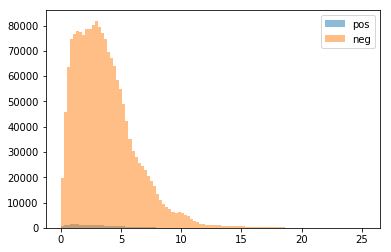

In [22]:
pair_dist = np.array(pair_dist)
pair_label = np.array(pair_label)

bins = np.linspace(pair_dist.min(), pair_dist.max(), 100)

plt.hist(pair_dist[pair_label], bins, alpha=0.5, label='pos')
plt.hist(pair_dist[pair_label == False], bins, alpha=0.5, label='neg')
plt.legend(loc='upper right')
plt.show()

In [23]:
# pair_dist = []
# pair_label = []

# for i in np.arange(x_train.shape[0]):
#     for j in range(i, x_train.shape[0]):
#         d = np.sqrt(np.power(x_train[i] - x_train[j], 2).sum())
#         pair_dist.append(d)
        
#         if y_train[i] == y_train[j]:
#             pair_label.append(True)
#         else:
#             pair_label.append(False)
    
# print roc_auc_score(y_true=pair_label, y_score=pair_dist)

In [24]:
mean = np.mean(x_test_encoded[0], axis=0)
print mean

std = np.std(x_test_encoded[0], axis=0)
print std

[ 1.616926  -1.8897362]
[2.5562718 1.8632553]


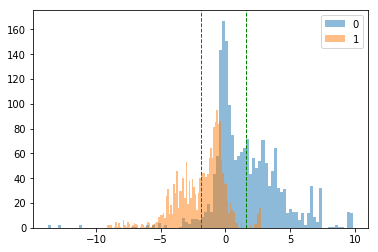

In [25]:
plt.hist(x_test_encoded[0, :, 0], bins=100, alpha=0.5, label='0')
plt.hist(x_test_encoded[0, :, 1], bins=100, alpha=0.5, label='1')

plt.axvline(mean[0], color='green', linestyle='dashed', linewidth=1)
plt.axvline(mean[1], color='red', linestyle='dashed', linewidth=1)

plt.legend()
plt.show()

### Apply Generative Probabilistic Model

In [99]:
N_SINGLETONS = 65
N_PAIRS = 5

In [100]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87])

In [101]:
singletons = np.random.choice(range(y_train.max() + 1), N_SINGLETONS, replace=False)
# pairs = np.random.choice( )
print singletons

[67 42 75 40 43 28 85 53 21 18 37 71 79  2 13 52 45 23 38 20 77 82  4 10
 59 46 19  7  1  8 78 31 11 32 66 68 84 83  0 61 63 49 73 60 35 26 14 30
 17 50 48 29 69 25 62  9 80 58 70 65 33 15 41 51 22]


In [102]:
remaining_idx = []
for i in np.arange(y_train.max() + 1):
    if i not in singletons:
        remaining_idx.append(i)
print remaining_idx

[3, 5, 6, 12, 16, 24, 27, 34, 36, 39, 44, 47, 54, 55, 56, 57, 64, 72, 74, 76, 81, 86, 87]


In [103]:
pairs = np.random.choice(remaining_idx, N_PAIRS, replace=False)
print pairs

[39 64 27 34  5]


In [104]:
vec_list = []
labels = []
GT_POS_PAIRS = []

pid_list = data_dict.keys()

for p in range(len(pairs)):
    pid = pid_list[pairs[p]]
#     print pid
    w1, w2 = np.random.choice(data_dict[pid].keys(), 2)
#     print w1, w2
    app_vec1, app_vec2 = data_dict[pid][w1], data_dict[pid][w2]
    
    vec_list.append(app_vec1)
    vec_list.append(app_vec2)
    
    labels.append(p + 1)
    labels.append(p + 1)
    GT_POS_PAIRS.append((2* p, 2* p + 1))

for s in singletons:
    pid = pid_list[s]
    w = np.random.choice(data_dict[pid].keys(), 1)
#     print pid
#     print w
    app_vec = data_dict[pid][w[0]]
    vec_list.append(app_vec)
    labels.append(0)

In [105]:
vec_list = np.array(vec_list)

In [106]:
test_encoded_imgs = encoder.predict(vec_list)
test_decoded_imgs = decoder.predict(test_encoded_imgs[2])

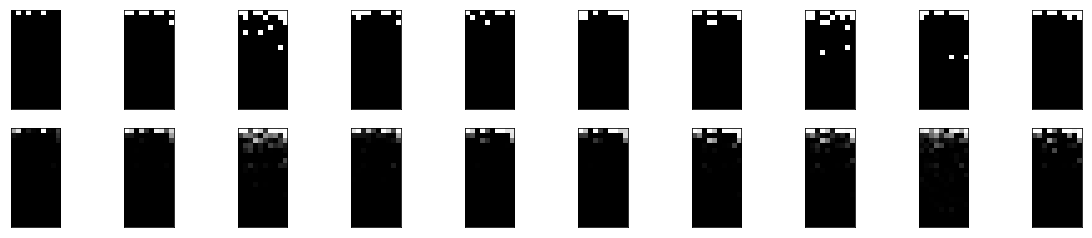

In [107]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(vec_list[i, :200].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_decoded_imgs[i, :200].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [108]:
points = encoder.predict(np.array(vec_list))[2]

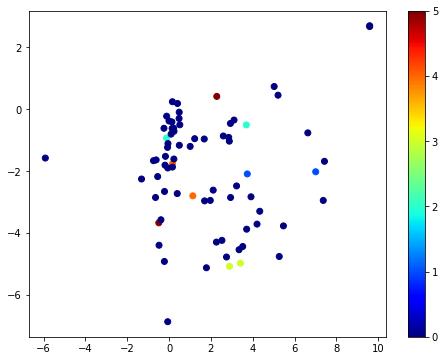

In [109]:
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='jet')
plt.colorbar()
plt.show()

In [110]:
N_DIM = len(points.shape)
test_mean = np.mean(points, axis=0)
print test_mean
sigma = np.std(points)
print np.std(points, axis=0)
print sigma

[ 1.8650869 -1.961528 ]
[2.6298435 1.809135 ]
2.95893


In [111]:
nu = 0.1

In [112]:
start = time()

LR_arr = []
LR_idx = []

dist_matrix = np.zeros((points.shape[0], points.shape[0]))
adj_matrix = np.zeros((points.shape[0], points.shape[0]))

for i in np.arange(points.shape[0]):
    for j in np.arange(i + 1, points.shape[0]):
        midpoint = 0.5 * (points[i] + points[j])
        m = euclidean(midpoint, test_mean)
        d = euclidean(0.5* (points[i] - points[j]), [0,0])
        
        m_prime = m / sigma
        d_prime = d / sigma
        t = nu / sigma
        
        LR = np.power(0.5/t, N_DIM)* np.exp(0.5*(np.power(m_prime,2)+ np.power(d_prime,2)*(2- np.power(t,-2))))
        LR_arr.append(LR)
        dist_matrix[i, j] = LR
        
        if (i, j) in GT_POS_PAIRS:
            LR_idx.append(True)
            adj_matrix[i, j] = 1
        else:
            LR_idx.append(False)
            adj_matrix[i, j] = 0
            
print 'time elapsed: %f s' % (time() - start)

LR_arr = np.array(LR_arr)
LR_idx = np.array(LR_idx)

time elapsed: 0.279406 s


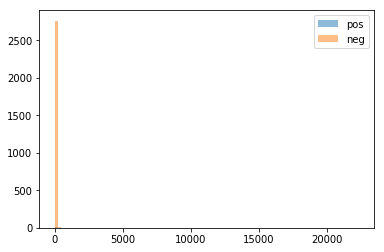

In [113]:
bins = np.linspace(LR_arr.min(), LR_arr.max(), 100)

plt.hist(LR_arr[LR_idx], bins, alpha=0.5, label='pos')
plt.hist(LR_arr[LR_idx == False], bins, alpha=0.5, label='neg')
plt.legend(loc='upper right')
plt.show()

In [114]:
print roc_auc_score(y_true=LR_idx, y_score=LR_arr)

0.6147292418772563


In [75]:
dist_matrix = dist_matrix + dist_matrix.transpose()
print dist_matrix

[[0.00000000e+000 4.93595301e+002 0.00000000e+000 ... 5.81601355e-172
  4.17656960e-163 1.69624878e-308]
 [4.93595301e+002 0.00000000e+000 0.00000000e+000 ... 4.57121213e-161
  1.66047308e-152 3.24742988e-295]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 1.55352044e-082
  5.11304976e-088 2.02158273e-019]
 ...
 [5.81601355e-172 4.57121213e-161 1.55352044e-082 ... 0.00000000e+000
  2.14621988e+002 4.97468585e-020]
 [4.17656960e-163 1.66047308e-152 5.11304976e-088 ... 2.14621988e+002
  0.00000000e+000 4.41784349e-023]
 [1.69624878e-308 3.24742988e-295 2.02158273e-019 ... 4.97468585e-020
  4.41784349e-023 0.00000000e+000]]


In [77]:
adj_matrix = adj_matrix + adj_matrix.transpose()
print adj_matrix

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [93]:
rank = [1,5]

for r in rank:
    hit = 0
    tot = 0.0
    
    for i in np.where(adj_matrix == 1)[0]:
        idx = np.argsort(dist_matrix[i])[::-1]
        if 1 in adj_matrix[i, idx][:r]:
            hit += 1
        tot += 1
    
    print 'rank %d: %f' % (r, hit / tot)

rank 1: 0.700000
rank 5: 1.000000


In [89]:
AP_list = []
for i in np.where(adj_matrix == 1)[0]:
    ap = average_precision_score(y_true=adj_matrix[i], y_score=dist_matrix[i])
    AP_list.append(ap)
print 'mAP: %f' % (np.mean(AP_list))

mAP: 0.816667
